In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense

from matplotlib import pyplot
%matplotlib inline

Using TensorFlow backend.


### Introduction

This is an experiment in time series forecasting, using recurrent neural network (RNN). Time series data is a set of access log entries, containing timestamps. One can solve the problem with other methods, such as manual feature engineering + xgboost, etc.

After looking at data, I will formulate the problem I want to solve and will translorm data to fit the problem. I will then provide 2 solutions: a simple baseline solution and RNN solution. After evaluating the RNN solution, I will end up with short discussion on ways to improve it.

### Raw data

In [2]:
df = pd.read_csv('access_logs_201612.txt', sep=' ', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,147.214.18.128,-,-,2016-11-27,03:16:03,100,GET /rawdata-dispatcher/progress/count?executi...,rc:200,22,-,Apache-HttpClient/4.3.3 (java 1.5),in:244,out:223,us:2545
1,147.214.18.128,-,-,2016-11-27,03:16:05,100,GET /rawdata-dispatcher/progress/count?executi...,rc:200,21,-,Apache-HttpClient/4.3.3 (java 1.5),in:244,out:222,us:2187
2,localhost,-,-,2016-11-27,03:16:07,100,GET /server-status?auto HTTP/1.1,rc:200,387,-,collectd/5.5.1,in:94,out:585,us:475
3,147.214.18.128,-,-,2016-11-27,03:16:08,100,GET /rawdata-dispatcher/progress/count?executi...,rc:200,22,-,Apache-HttpClient/4.3.3 (java 1.5),in:244,out:223,us:1835
4,147.214.18.128,-,-,2016-11-27,03:16:08,100,GET /rawdata-dispatcher/progress/list?executio...,rc:200,4554,-,Apache-HttpClient/4.3.3 (java 1.5),in:259,out:4757,us:3021


This is a typical access log entry, showing what requests are made to a server, along with request info such as the origin of a request (column 0), the time it is made (columns 3 and 4), etc.

In such system one might want to know how many requests per time unit are expected in the near future (e.g in the coming 24 hours). Knowing this can be used for tasks such as resource optimization, where one uses various number of servers to respond well to request spikes.

For training efficiency, I will transform log data to requests per hour, so there is less data to work with.

### Transformed data

In [3]:
def load_logfile():
    df = pd.read_csv(
        'access_logs_201612.txt', 
        sep=' ', 
        header=None, 
        parse_dates={'timestamp': [3, 4]}, 
        date_parser=lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
    )
    df['dayofyear'] = df.timestamp.dt.dayofyear
    df['hour'] = df.timestamp.dt.hour
    data = pd.DataFrame(df.groupby(['dayofyear', 'hour'])
                        .count()
                        .reset_index()
                       ).rename(columns={'timestamp': 'requests_per_hour'})
    return data['requests_per_hour']

In [4]:
requests_per_hour = load_logfile()

In [5]:
requests_per_hour.head()

0    5163
1    7129
2    7593
3    8951
4    5429
Name: requests_per_hour, dtype: int64

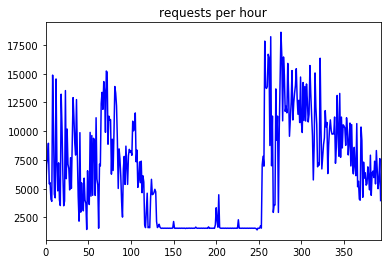

In [6]:
requests_per_hour.plot(title='requests per hour', color='blue')

We see that in the first hour there were 5163 requests, followed by 7129 requests in the second hour, etc. The graph above shows all request counts.

In [7]:
len(requests_per_hour)

394

In [8]:
num_test = 24

There are 394 data entries. I will try to predict the counts for the last 24 (num_test) hours in this sequence.

### Baseline

Since I want to evaluate the performance of the RNN model, I need a baseline model to evaluate against. One possible prediction/model of the number of requests in the next hour is to say that there will be as many as in the current hour. This is obviously quite an naive approach but it makes a good baseline. That is, if RNN does not perform better than baseline, RNN would not be a good approach to solve this problem.

In [9]:
Y = requests_per_hour[-num_test:]

In [10]:
Preds = Y.shift().values
Preds[0] = requests_per_hour[len(requests_per_hour)-num_test-1]
Y = Y.values

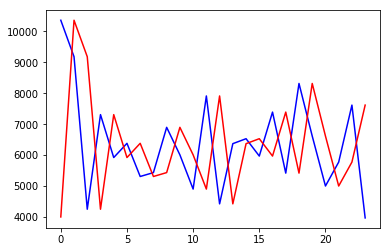

In [11]:
pyplot.plot(Y, color='blue')
pyplot.plot(Preds, color='red')

In [12]:
baseline_mse = mean_squared_error(Y, Preds)
baseline_mse

6064985.166666667

I measure mean squared error (mse) because it is the metric I use in the RNN model below.

### RNN model

In [13]:
def scale(X):
    scaler = MinMaxScaler(feature_range=[-1, 1])
    X = X.astype('float64')
    X = scaler.fit_transform(X.values.reshape(-1, 1))
    return scaler, pd.Series(X.flatten())

In [14]:
scaler, X = scale(requests_per_hour)

I scale data in the range [1-, 1] since it is the range used by the LSTM activation function in the RNN model below. Then I split data into train and test parts.

I train the model with x_train, y_train. Then I make predictions on x_test and compare them with y_test.

In [15]:
def get_xy(X):
    Y = X
    X = X.shift()
    X[0] = 0
    assert len(X) == len(Y)
    return X, Y

In [16]:
X, Y = get_xy(X)

In [17]:
def get_train_test(X, Y, num_test=int(0.2*len(X))):
    return X[:-num_test], Y[:-num_test], X[-num_test:], Y[-num_test:]

In [18]:
x_train, y_train, x_test, y_test = get_train_test(X, Y, num_test=num_test)

In [19]:
len(x_train), len(y_train), len(x_test), len(y_test)

(370, 370, 24, 24)

#### Create model

In [20]:
def get_model(units=1, batch_input_shape=(1, 1, 1)):
    model = Sequential([
        LSTM(units=units, stateful=True, batch_input_shape=batch_input_shape),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

Simple stateful model with mse (mean square error) loss function.

In [21]:
def fit_model(x, y, units=1, epochs=10, verbose=0):
    model = get_model(units=units)
    for i in range(epochs):
        model.fit(
            x.values.reshape(x.shape[0], 1, 1), 
            y, 
            batch_size=1, 
            epochs=1, 
            shuffle=False,
            verbose=verbose,
            validation_split=0.2
        )
        model.reset_states()
    return model

The model is trained with x.shape[0] samples, to generate 1 prediction ahead, with sample size of 1 (requests per hour count). I set suffle to False to keep the ordered nature of data.

In [22]:
model = fit_model(x_train, y_train, units=5, epochs=5)

#### Are we under/overfitting?

In [23]:
def predict_visualize(x, y, scaler):
    preds = model.predict(x.values.reshape(x.shape[0], 1, 1), batch_size=1)
    y_inv = scaler.inverse_transform(y.values.reshape(-1, 1))
    preds_inv = scaler.inverse_transform(preds)

    pyplot.title('Actual vs. predicted requests per hour')
    pyplot.plot(y_inv, color='blue')
    pyplot.plot(preds_inv, color='red')
    
    rnn_mse = mean_squared_error(y_inv, preds_inv)
    return rnn_mse

7348315.5062668156

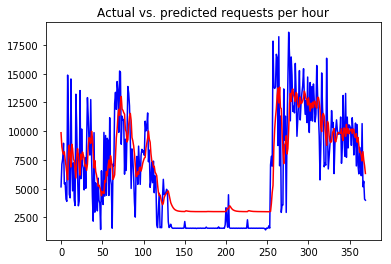

In [24]:
predict_visualize(x_train, y_train, scaler)

Unsuprisingly (due to the low number of epochs) the model doesn't model data very well, that is it has high bias, so it underfits data. Some ways to solve this is to increase the number of epochs in training and/or to increase the model complexity, e.g. number of units.

#### Predict and visualize

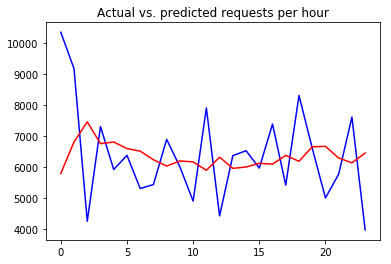

In [25]:
rnn_mse = predict_visualize(x_test, y_test, scaler)

### Model comparision

In [26]:
rnn_mse < baseline_mse

True

The RNN model seems better than baseline since its error is smaller. For better/more robust estimate of the RNN model performance one needs to take the average/median mse from multiple train/predict phases. Yet the model suffers from high bias, so it requires improvement.

### Next steps 

The RNN solution might be improved in different ways. Some thigs worth trying are the following:

* Grid search to find better parameter values for (at least) number of epochs and LSTM units (see high bias above)
* Helping the model by adding domain knowledge/"hand-made" features such as dayofweek or day/night
* Using alternative architecture, e.g stacking stateless LSTMs, etc